In [ ]:
import numpy as np
import xarray as xr
import datetime

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font',**{'size':18})

In [ ]:
from ftplib import FTP
import wget

In [ ]:
yr_beg = 2018
yr_end = 2020

In [ ]:
#c download data from server
for yr in range(yr_beg, yr_end+1):
    with FTP('aftp.cmdl.noaa.gov') as ftp:
        ftp.login()
        ftp.cwd('data/radiation/surfrad/Penn_State_PA/'+str(yr)) # change directory
        files = ftp.nlst() # list files in the directory
        for file in files:
            wget.download('ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/Penn_State_PA/'+str(yr)+'/'+file)
            
ndays_lastyear = len(files) # number of days in yr_end

In [ ]:
#c an alternative to using ftplib and wget
# !wget -r ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/Penn_State_PA/201[7-9]

In [ ]:
def daysinayear(year):
    if year%400 == 0:
        return 366
    elif year%100 == 0:
        return 365
    elif year%4 == 0:
        return 366
    return 365

In [ ]:
#c list of fields, copied from the Fortran code in README
fields = ['year', 'jday', 'month', 'day', 'hour', 'min', 'dt', 'zen', 'dw_solar', 'qc_dwsolar', 'uw_solar', 'qc_uwsolar', 'direct_n', 'qc_direct_n', 'diffuse', 'qc_diffuse', 'dw_ir', 'qc_dwir', 'dw_casetemp', 'qc_dwcasetemp', 'dw_dometemp', 'qc_dwdometemp', 'uw_ir', 'qc_uwir', 'uw_casetemp', 'qc_uwcasetemp', 'uw_dometemp', 'qc_uwdometemp', 'uvb', 'qc_uvb', 'par', 'qc_par', 'netsolar', 'qc_netsolar', 'netir', 'qc_netir', 'totalnet', 'qc_totalnet', 'temp', 'qc_temp', 'rh', 'qc_rh', 'windspd', 'qc_windspd', 'winddir', 'qc_winddir', 'pressure', 'qc_pressure', 'count']
nfields = len(fields) # number of fields in each .dat plus one

In [ ]:
# path = '/home/aos/hsiehtl/GEO202_surf_rad/surfrad_PSU/' # path to data files
# path = 'aftp.cmdl.noaa.gov/data/radiation/surfrad/Penn_State_PA/' # if using !wget

data = np.zeros((1, nfields)) # initial shape is specified to make np.append() work
for year in range(yr_beg, yr_end+1):
    if year == yr_end:
        ndays = ndays_lastyear
    else:
        ndays = daysinayear(year) # number of days in that year
    
    for day in range(1, ndays+1):
        singleday = np.zeros((24, nfields)) # to hold hourly data for one day
        
        # filepath = path+str(year)+'/psu'+str(year)[-2:]+str(day).zfill(3)+'.dat' # if using !wget
        filepath = 'psu'+str(year)[-2:]+str(day).zfill(3)+'.dat'
        
        try: 
            file = open(filepath, 'r') # each .dat is a day of data
        
            #v skip header lines
            file.readline()
            file.readline()

            for line in file:
                l = np.array(line.split())
                hr = int(l[4])
                singleday[hr,:-1] = singleday[hr,:-1] + np.array([float(n) for n in l])
                singleday[hr,-1]  = singleday[hr,-1]  + 1 # counting number of samples in each hour; may not be 60
                
            singleday[:,:-1] = singleday[:,:-1]/np.transpose(np.broadcast_to(singleday[:,-1], (nfields-1, 24))) # computing hourly mean
            
            file.close()
            
        except FileNotFoundError: # to append zeros for days with missing data
            pass
        
        data = np.append(data, singleday, axis=0)
    
data = data[1:,:] # removing the first line of zeros

In [ ]:
#c cleaning up quality control flags
for i in range(nfields):    
    if fields[i][:2] == 'qc':
        data[:,i] = data[:,i] + (data[:,-1] == 0) # flaging the entry if count == 0
        data[:,i] = (data[:,i] > 0) # making it boolean data

In [ ]:
ds = xr.Dataset()
h = range(len(data)) # a simple time axis: hours from the first data point

for i in range(nfields):
    if i < 6 or fields[i][:2] == 'qc' or i == nfields-1: # cleaning up variable type
        ds.__setitem__(fields[i], xr.DataArray(data[:,i].astype(np.int32), coords=[h], dims=['time']))
    else:
        ds.__setitem__(fields[i], xr.DataArray(data[:,i], coords=[h], dims=['time']))

In [ ]:
ds.to_netcdf('surfrad_hourly.nc')

#### Creating ds2: using datetime list as the time axis

In [ ]:
ds = xr.open_dataset('surfrad_hourly.nc')

In [ ]:
#c replace time axis of "hours from" with datetime list
ds2 = xr.Dataset()

first = datetime.datetime(ds.year[0].values, ds.month[0].values, ds.day[0].values, ds.hour[0].values)
time = [first + datetime.timedelta(hours=x) for x in range(len(ds.year.values))]

for field in fields:
    ds2.__setitem__(field, xr.DataArray(ds[field], coords=[time], dims=['time']))

In [ ]:
ds2.to_netcdf('surfrad_hourly_new.nc')

#### Creating ds3: removing qc flags; replacing bad data with nan

In [ ]:
ds2 = xr.open_dataset('surfrad_hourly_new.nc')

In [ ]:
ds3 = xr.Dataset()

for i in range(nfields):
    if fields[i][:2] == 'qc':
        ds2[fields[i-1]][ds2[fields[i]] == 1] = np.nan # make bad quality data nan
        ds3.__setitem__(fields[i-1], ds2[fields[i-1]]) # NOTE: only data with qc flags are included, not including the time variables
        
for field in ['zen']: # fields that don't have qc flags but still worth including
    ds3.__setitem__(field, ds2[field])

In [ ]:
ds3.to_netcdf('surfrad_hourly_clean.nc')

#### ds4: adding year, month and other time variables back

In [ ]:
import pandas as pd

In [ ]:
ds3 = xr.open_dataset('surfrad_hourly_clean.nc')

In [ ]:
ds4 = xr.Dataset()
fields_to_keep = ['dw_solar', 'uw_solar', 'dw_ir', 'uw_ir', 'uvb', 'temp', 'rh', 'windspd', 'winddir', 'pressure']

time = pd.to_datetime(ds3.time.values + np.timedelta64(-5, 'h')) # in local (EST) time zone
for field in fields_to_keep:
    ds4.__setitem__(field, xr.DataArray(ds3[field].values, coords=[time], dims=['time']))
ds4.__setitem__('zenith', xr.DataArray(ds3['zen'].values, coords=[time], dims=['time']))

ds4.__setitem__('year', xr.DataArray(time.year, coords=[time], dims=['time']))
ds4.__setitem__('month', xr.DataArray(time.month, coords=[time], dims=['time']))
ds4.__setitem__('day', xr.DataArray(time.day, coords=[time], dims=['time']))
ds4.__setitem__('hour', xr.DataArray(time.hour, coords=[time], dims=['time']))

ds4.__setitem__('hours_since', xr.DataArray(np.arange(len(time)), coords=[time], dims=['time']))

In [ ]:
ds4.to_netcdf('surfrad_hourly_simple.nc')

([<matplotlib.axis.XTick at 0x1178bb208>,
 <a list of 6 Text xticklabel objects>)

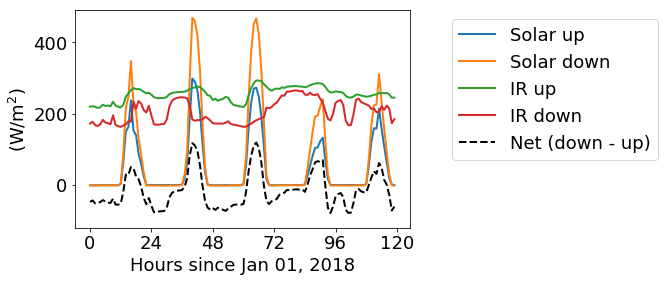

In [74]:
#c visualize the first 5 days of data
((ds.uw_solar))[:120].plot(label='Solar up', lw=2)
((ds.dw_solar))[:120].plot(label='Solar down', lw=2)
((ds.uw_ir))[:120].plot(label='IR up', lw=2)
((ds.dw_ir)*(1 - ds.qc_dwir))[:120].plot(label='IR down', lw=2)
((ds.totalnet))[:120].plot(label='Net (down - up)', lw=2, ls='--', c='k')

plt.ylim((-120, 490))
plt.xlabel('Hours since Jan 01, '+str(yr_beg))
plt.ylabel('(W/m$^2)$')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.0), fontsize=18) # right
plt.xticks(np.arange(0, 121, 24))